# AMI JWST Phase Retrieval on Simulated Data
In this notebook we will generate some fake AMI data and fit to it. The free parameters used in this model will be:
- Source Flux
- Source Position [not implemented error]
- $7 \times 6$ Hexike coefficients

This system faces the issue of global phase invariance -- if the pistons of each subaperture are shifted by the same amount, the PSF will be unchanged. To avoid this, we will subtract the mean piston from the piston coefficients at each step of the optimisation. This will remove any global phase degeneracies, and allow us to converge to the correct solution more accurately.

Importing relevant packages

In [1]:
import webbpsf
import dLux as dl
import dLuxWebbpsf as dlW

import numpy
import jax.numpy as np
import jax.random as jr

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import optax
import zodiax as zdx
import jax

from dLux.utils import deg_to_rad as d2r
import dLux.utils as dlu
from detector_layers import DistortionFromSiaf

plt.rcParams['image.origin'] = 'lower'

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


## Building NIRISS model

Here we will build our dLux forwards model of the NIRISS AMI PSF.

In [2]:
# Primary mirror - note this class automatically flips about the y-axis
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
webbpsfobj.pupil_mask = "MASK_NRM"
NIS_CEN_aperture = webbpsfobj.siaf.apertures["NIS_CEN"]
webbpsf_osys = webbpsfobj.get_optical_system()
planes = webbpsf_osys.planes

In [3]:
radial_orders = np.array([0, 1, 2], dtype=int)
hexike_shape = (7, int(np.sum(np.array([dl.utils.triangular_number(i+1) - dl.utils.triangular_number(i) for i in radial_orders]))))

true_flux = 1e6
true_coeffs = 1e-7 * jr.normal(jr.PRNGKey(0), hexike_shape)

In [4]:
npix = 1024
oversample = 4
pscale = (planes[-1].pixelscale).to("arcsec/pix").value
pupil_plane = planes[-2]

osys = dl.LayeredOptics(
    wf_npixels=1024,
    diameter=planes[0].pixelscale.to("m/pix").value * planes[0].npix,
    layers=[
        (dlW.optical_layers.JWSTAberratedPrimary(
            planes[0].amplitude,
            planes[0].opd,
            radial_orders=radial_orders,
            coefficients=true_coeffs,
            AMI=True,
        ), "Pupil"),
        (dl.Flip(0), "InvertY"),
        (dl.Optic(pupil_plane.amplitude), "Mask"),
        (dlW.MFT(npixels=oversample * 64, oversample=oversample, pixel_scale=pscale), "Propagator"),
    ]
)

src = dl.PointSource(flux=true_flux, **dict(np.load("filter_configs/F480M.npz")))
detector = dl.LayeredDetector(
    [
        dlW.detector_layers.Rotate(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
        DistortionFromSiaf(
            aperture=NIS_CEN_aperture
        ),  # TODO implement dLuxWebbpsf version
        dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    ]
)

instrument = dl.Instrument(sources=[src], detector=detector, optics=osys)

# Simulating fake data
Here we are using a "true" flux value of $10^6$ photons, and all the "true" coefficient values are randomly generated. We also want to include some bad pixels, so we will randomly select some pixels and set them to zero. And we will of course add some poisson noise to the data to simulate photon noise.

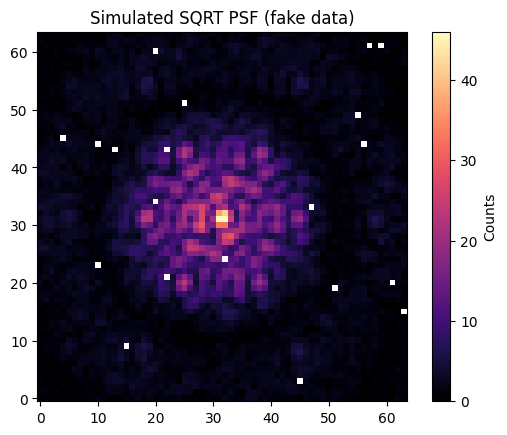

In [5]:
data = np.array(jr.poisson(jr.PRNGKey(0), instrument.model()))  # adding photon noise

# Generate random coordinates to set as NaN
n_bad = 20  # no. of bad pixels
random_coordinates = numpy.random.randint(0, 64, size=(int(n_bad), 2))  # random coordinates for bad pixels
bad_mask = numpy.zeros((64, 64), dtype=bool)
bad_mask[random_coordinates[:, 0], random_coordinates[:, 1]] = True
bad_mask = np.array(bad_mask)  # mask where bad pixels live

# Set the randomly selected coordinates to NaN (just for plotting
data_for_plotting = np.where(bad_mask, np.nan, data)
data = np.where(bad_mask, 0, data)
    
plt.imshow(data_for_plotting**.5, cmap='magma')
plt.title('Simulated SQRT PSF (fake data)')
plt.colorbar(label='Counts')
plt.show()

## Optimisation
Let's define our paths to our parameters inside of the instrument object.

In [6]:
flux_path = 'PointSource.flux'
coeffs_path = 'optics.Pupil.coefficients'

parameter_paths = [flux_path, coeffs_path]

Defining our model to be a copy of the instrument object, with random initial value of flux and all coefficients starting at zero.

In [7]:
# Multiply the fluxes by small random values
model = instrument.multiply(flux_path, 1 + 0.1*jr.normal(jr.PRNGKey(0)))

# Set the zernike coefficients to zero
model = model.set(coeffs_path, np.zeros(hexike_shape))

Creating our optimisers using optax - the `adam` algorithm is a gradient descent algorithm with momentum and acceleration terms to avoid falling trap to local minima.

In [8]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
flux_optimiser  = optax.adam(1e5, b1=0.85)
coeff_optimiser = optax.adam(2e-8)

# Combine the optimisers into a list
optimisers = [flux_optimiser, coeff_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameter_paths, optimisers)

Defining our least squares loss function and jitting it - this will make the function evaluation much faster in subsequent calls. The `filter_value_and_grad` function will return the value of the loss function and the gradient of the loss function with respect to the parameters we are optimising over, which we will use to walk downhill.

In [9]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameter_paths)
def loss_fn(model, data):
    out = np.where(bad_mask, 0, model.model())  # Set bad pixels to 0
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))
    # return np.sum(np.log10(np.abs(data - out)))

Checking the loss at our initial values.

In [10]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

Initial Loss: 19264
CPU times: user 5.04 s, sys: 698 ms, total: 5.73 s
Wall time: 3.21 s


Running gradient descent!

In [11]:
losses, models_out = [], []
iters = 200
with tqdm(range(iters), desc='Gradient Descent') as t:
    for i in t: 
        logloss, grads = loss_fn(model, data)    
        updates, opt_state = optim.update(grads, opt_state)
        
        unshifted_model = zdx.apply_updates(model, updates)
        mean_piston = unshifted_model.get(coeffs_path)[:, 0].mean()  # grabbing mean piston value
        mean_piston_array = np.hstack((  # creating array of mean piston values and zeros on all other coefficients
            -mean_piston * np.ones(shape=(hexike_shape[0], 1)),
            np.zeros(shape=(hexike_shape[0], hexike_shape[1]-1))
        ))
        model = unshifted_model.add(coeffs_path, mean_piston_array)  # subtracting mean piston from model
        # model = zdx.apply_updates(model, updates)
        
        losses.append(logloss)
        models_out.append(model)
        t.set_description("Log Log Loss: {:.3f}".format(np.log10(logloss))) # update the progress bar

Gradient Descent:   0%|          | 0/500 [00:00<?, ?it/s]

Grabbing the output.

In [12]:
psfs_out = models_out[-1].model()

flux_found = np.array([model.get(flux_path) for model in models_out])
coeffs_found = np.array([model.get(coeffs_path) for model in models_out])

In [13]:
coeffs_residuals = true_coeffs - coeffs_found
flux_residuals = true_flux - flux_found

Plotting loss and residuals.

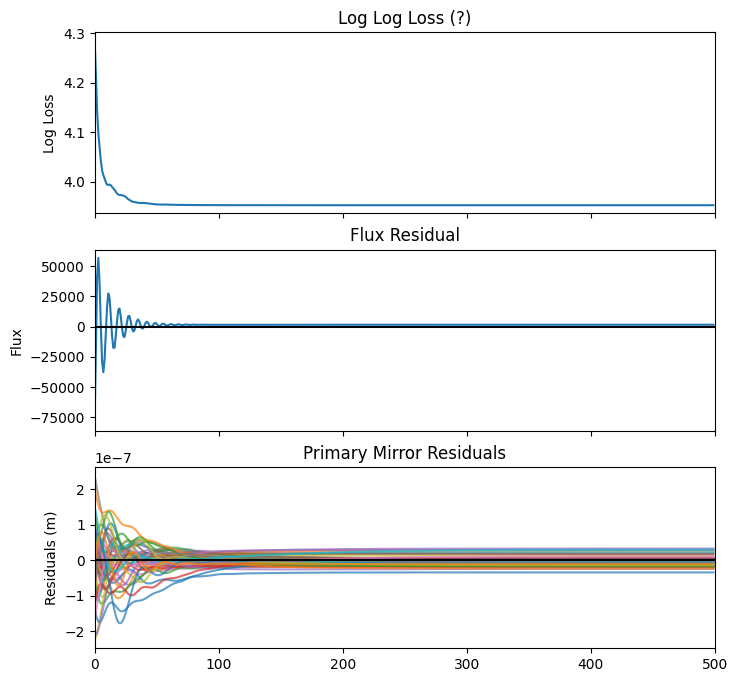

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax[0].plot(np.log10(np.array(losses)))
ax[0].set(title='Log Log Loss (?)', ylabel='Log Loss', xlim=(0, iters))

ax[1].plot(flux_residuals)
ax[1].set(title='Flux Residual', ylabel='Flux')
ax[1].axhline(0, color='k')

ax[2].plot(coeffs_residuals.reshape((coeffs_residuals.shape[0], coeffs_residuals.shape[1]*coeffs_residuals.shape[2])), alpha=0.7)
ax[2].set(title='Primary Mirror Residuals', ylabel='Residuals (m)')
ax[2].axhline(0, color='k')

plt.show()

Checking out the OPD!

In [15]:
pupil_support = np.flip(instrument.Mask.transmission, (0,1))
support_mask = np.where(pupil_support > 0.5)

true_opd = instrument.Pupil.basis_opd
opds_found = np.array([model.Pupil.basis_opd[support_mask] for model in models_out])
opd_found = models_out[-1].Pupil.basis_opd
opd_residuals = true_opd[support_mask] - opds_found

opd_rmse_nm = 1e9*np.mean(opd_residuals**2, axis=(-1))**0.5

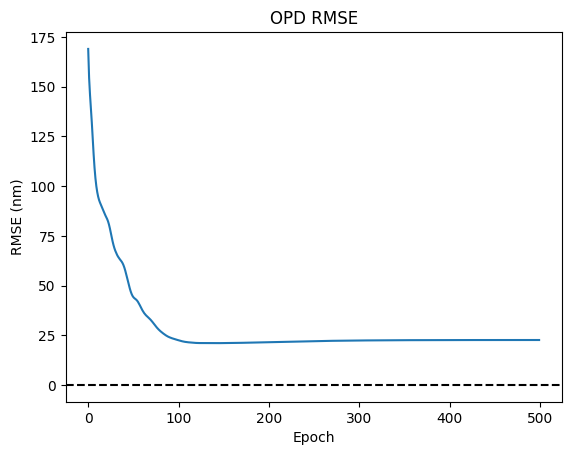

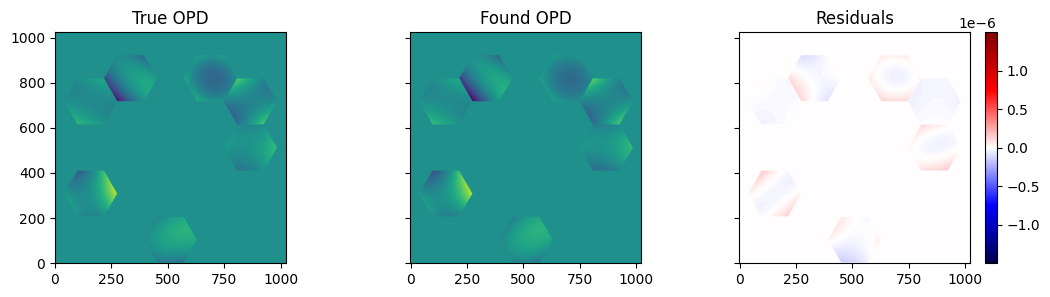

In [16]:
vmin = np.min(np.array([true_opd, opd_found]))
vmax = np.max(np.array([true_opd, opd_found]))
bound = np.max(np.array([-vmin, vmax]))

fig, ax = plt.subplots()
ax.plot(opd_rmse_nm)
ax.set(title='OPD RMSE', xlabel='Epoch', ylabel='RMSE (nm)')
ax.axhline(0, color='k', linestyle='--')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(13,3), sharey=True)
ax[0].imshow(true_opd, vmin=-bound, vmax=bound)
ax[0].set(title='True OPD')

ax[1].imshow(opd_found, vmin=-bound, vmax=bound)
ax[1].set(title='Found OPD')

c = ax[2].imshow(true_opd - opd_found, vmin=-bound, vmax=bound, cmap='seismic')
ax[2].set(title='Residuals')
fig.colorbar(c)
plt.show()

Visualising the accuracy of the coefficients (love this plot, thanks Louis)

In [17]:
def radial_to_noll(radial_orders):
    noll_indices = []
    for order in radial_orders:
        start = dlu.triangular_number(order)
        stop = dlu.triangular_number(order + 1)
        noll_indices.append(np.arange(start, stop) + 1)
    return np.concatenate(noll_indices, dtype=int)  
    
flat_true_coeffs = true_coeffs.flatten()
    
# Coefficients
flat_found_coeffs = coeffs_found[-1].flatten()
index = np.arange(len(flat_found_coeffs))

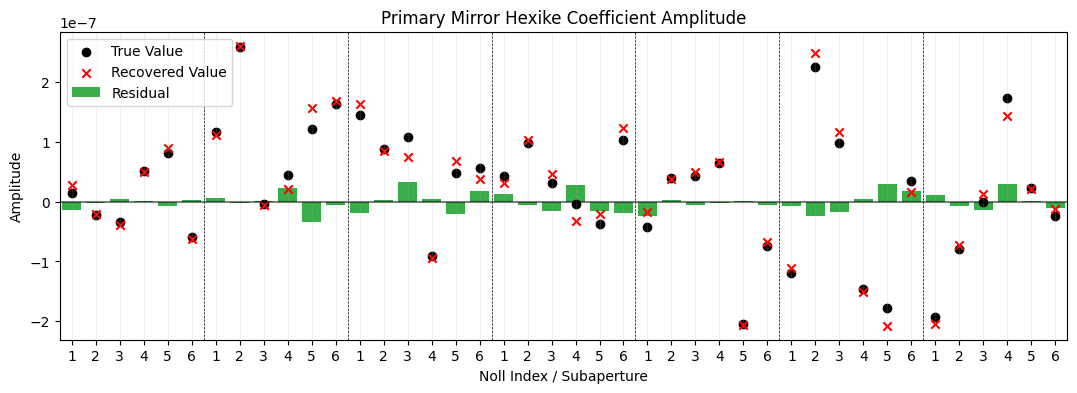

In [18]:
# Plotting Primary
plt.figure(figsize=(13, 4))
plt.title("Primary Mirror Hexike Coefficient Amplitude")
plt.xlabel("Noll Index / Subaperture")
plt.ylabel("Amplitude")
plt.xticks(np.arange(hexike_shape[0]*hexike_shape[1]), 7*list(radial_to_noll(radial_orders)))
plt.xlim(-0.5, hexike_shape[0]*hexike_shape[1] - 0.5)
for n in range(1, 7):
    plt.axvline(n*hexike_shape[1] - 0.5, linestyle='--', c='k', linewidth=0.5)
plt.grid(alpha=0.2, axis='x')
plt.scatter(index, flat_true_coeffs, label="True Value", c='k')
plt.scatter(index, flat_found_coeffs, label="Recovered Value", marker='x', c='red')
plt.bar(index, flat_true_coeffs - flat_found_coeffs, label='Residual', color='#39ad48', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()

Finally, looking at the PSF residuals.

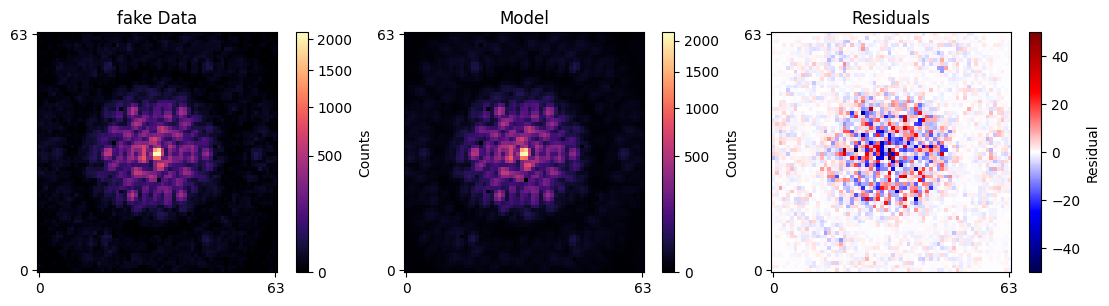

In [19]:
from utils import plot_and_compare
plot_and_compare(data, np.where(bad_mask, 0, model.model()), titles=['fake Data', 'Model'], colorbars=True, cbar_label='Counts', stretch='sqrt')

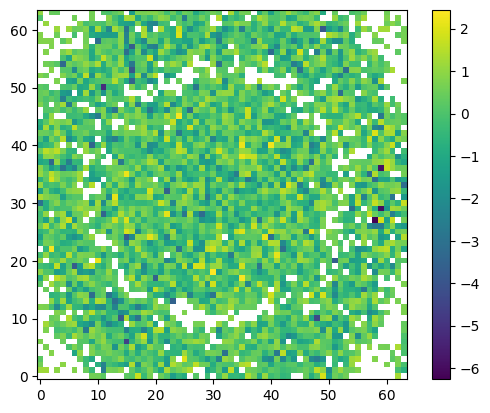

In [29]:
residual = data - np.where(bad_mask, np.nan, model.model())
rel_resid = residual / data**0.5
plt.imshow(rel_resid)
plt.colorbar()
plt.show()